# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [ ]:
!pip install torch
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import nn, Tensor
from torch.distributions import Distribution, Bernoulli
from typing import *

Mounted at /content/drive


In [ ]:
userID = 'Sara' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [ ]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [ ]:
try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)
# Various parameters

filter_seq = 5 #trade-off: might yield multiple classes in one sequence 
label = 'label2' 

In [ ]:
class ImageTensorDataset(torch.utils.data.Dataset):

    def __init__(self, df, image_data, filter_seq=filter_seq, label=label):
        # consider sequences of length 5
        self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(filter_seq, -1, -1)], axis = 1) 
        self.seq = self.seq[df['segment_ix'] >= filter_seq]
        
        self.labels = df[df['segment_ix'] >= filter_seq][label].values        
        self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values
        self.image_ix = df[df['segment_ix'] >= filter_seq]['image_ix'].values        
        self.image_data = image_data # why?
        tod = df[df['segment_ix'] >= filter_seq]['tod'].values # what ? 
        self.tod_one_hot = np.eye(5)[tod]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        image = self.image_data[self.user_id[key]][self.image_ix[key]]
        return image, self.seq[key], self.tod_one_hot[key], self.labels[key]

### Load train, validation and test data

In [ ]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random = True)
user_train = [user for user in user_train if user!=4]
user_test = [user for user in user_test if user!=9]
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7]


### Set time interval and speed cut off

In [ ]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [ ]:
# change index to 0/1
dataset.label2 = dataset.label2-1

In [ ]:
# image_ix:             ???
# segment_point_count:  length of minimum seq to infer on
# segment_ix:           step in trip
# segment_id:           where we are on grid ? (each sequence is split by cutoff_speed/time and labelled)
# tod:                  ???

In [ ]:
dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606


In [ ]:
data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train if tr != 4]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val if va != 4]).reset_index(drop=True)

In [ ]:
data_train = data_train[data_train['segment_ix'] >= filter_seq]
data_val = data_val[data_val['segment_ix'] >= filter_seq]

In [ ]:
NUM_CLASSES = 2
class_weights = [(data_train[label] == 0).sum()/(data_train[label] == x).sum() for x in range(NUM_CLASSES)]
#class_weights[-2:] = [np.max(class_weights[:-2]), np.max(class_weights[:-2])]
class_weights

[1.0, 3.0267842886795466]

### Load precomputed image frames

In [ ]:
image_data = {}
#for user_id in user_train + user_val + user_test:
for user_id in user_train + user_val:
      #if user_id != 4: #This is not relevant for the test partition. Again, this is for technical limitations, and for consistency with the above fix.
      image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
      print(image_data[user_id].shape[0])

17990
17990
2344
86277
28845
112
83326
20132


## Example Input/output data from ``TensorDataset``

In [ ]:
#np.prod(X_img.shape) + np.prod(X_seq.shape) + np.prod(X_tod.shape)

In [ ]:
demo_dataset = ImageTensorDataset(data_train, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=2, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([2, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([2, 6, 2])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
X_tod : torch.Size([2, 5])
tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
y : torch.Size([2])
tensor(0)


#### Define Data Loaders

In [ ]:
## HYPER PARAMETERS
# Network Parameters
IMG_INPUT_H_W = 9, 9
IMG_INPUT_C = 1 #11
TOD_INPUT_DIM = 6 
CNN_HIDDEN_DIM = 16
CNN_HIDDEN_DIM_2 = 8
CNN_KERNEL_SIZE = 3
CNN_PADDING = 1

SEQ_LENGTH = filter_seq + 1
SEQ_FEATURES = 2
TOD_INPUT_DIM = 5
RNN_HIDDEN_DIM = 4
RNN_NUM_LAYERS = 2
RNN_BIDIRECT = True
FC_HIDDEN_DIM = 256
DROPOUT_PROP = 0.45

latent_features = 2

# Training Parameters
NUM_EPOCH = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.01
LEARNING_DECAY_FACTOR = 10
LEARNING_DECAY_EPOCHS = [10]
## end of parameters

In [ ]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

def conv2d_output_shape(h_w, kernel_size=1, stride=1, padding=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sample_epsilon()*self.sigma
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -((z - self.mu) ** 2) / (2 * self.sigma ** 2) - self.sigma.log() - math.log(math.sqrt(2 * math.pi))


In [ ]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8) 
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
#test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

#### Define model, optimizer and loss

In [ ]:
#images1 = X_img
#print(images1.shape)
#images1 = images1[:,:,:,1]
print(X_img.shape)
images = (X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(2,9,9,1)
print(images.shape)

#images = torch.empty([10,81])
#print(images.shape)
#for i, x in enumerate(images1):
#  print(x.shape)
#  images[i] = x.view(9**2)

#images.shape

torch.Size([2, 9, 9, 11])
torch.Size([2, 9, 9, 1])


In [ ]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        #self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`

        # Pipeline [channels, height, width]:
        # CNN: [1, 9, 9] --> [32, 9, 9] --> [32, 4, 4] --> [16, 4, 4] --> [16, 2, 2]
        self.encoder_CNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        ) 
        # Pipeline
        # (First: reshape from [channels, height, width] to [channels * height * width])
        # [16, 2, 2] –-> 64 
        # FNN: 64 --> 128
        self.encoder_fnn1 = nn.Sequential(
            nn.Linear(in_features=64, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=2*32), # because of 32 latent features
            nn.BatchNorm1d(2*32),
            nn.ReLU(),
            nn.Dropout(0.3)
            #nn.Linear(in_features=64, out_features=2*latent_features)
        )
        #self.encoder_fnn2 = nn.Sequential(
        #    nn.Linear(in_features=self.observation_features, out_features=256),
        #    nn.ReLU(),
        #    nn.Linear(in_features=256, out_features=128),
        #    nn.ReLU(),
        #    nn.Linear(in_features=128, out_features=64),
        #    nn.ReLU(),
        #    # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
        #    nn.Linear(in_features=64, out_features=2*latent_features) # <- note the 2*latent_features
        #)
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder_fnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=128), # in_features = latent_features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
        #self.decoder = nn.Sequential(
        #    nn.Linear(in_features=latent_features, out_features=128),
        #    nn.ReLU(),
        #    nn.Linear(in_features=128, out_features=256), # added layer
        #    nn.ReLU(), # added activation
        #    nn.Linear(in_features=256, out_features=self.observation_features)
        #)
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        x_out = self.encoder_CNN(x)
        #print('11: ', x_out.shape)
        x_out = x_out.reshape(x_out.size(0), -1)
        #print('22: ', x_out.shape)
        #x_out = x_out.reshape(64)
        #print('33: ', x_out.shape)
        x_out = self.encoder_fnn1(x_out)
        #print("2 :", x_out.shape)
        mu, log_sigma =  x_out.chunk(2, dim=-1)
        #print("3: ", mu.shape)
        
        # return a distribution `q(z|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        #print("1: ", self.prior_params.shape[-1:])
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        #print("4: ", prior_params.shape)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        #px_logits = self.decoder(z)
        #print(shape(z))
        #x.view(z.shape)
        x = self.decoder_fnn(z)
        x = x.reshape(-1, 16, 2, 2) # reshape to fit output of self.encoder() and input of decoder
        # interpolate from [16, 2, 2] --> [16, 4, 4] (inverse maxpooling ish)
        x = nn.functional.interpolate(x, size=[4,4], mode='bilinear', align_corners=False)
        x = self.decoder1(x)
        # interpolate from [16, 4, 4] --> [16, 9, 9] (inverse maxpooling ish)
        x = nn.functional.interpolate(x, size=[9,9], mode='bilinear', align_corners=False)
        px_logits = self.decoder2(x)

        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

latent_features = 32
print(images[0].reshape(1,9,9,1).shape)
vae = VariationalAutoencoder(images[0].reshape(1,9,9,1).shape, latent_features)
print(vae)

torch.Size([1, 9, 9, 1])
VariationalAutoencoder(
  (encoder_CNN): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_fnn1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [ ]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x.float())
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px# <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [ ]:
images[0].reshape(1,9,9,1).shape
images.shape

torch.Size([2, 9, 9, 1])

In [ ]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, images.reshape(2,9,9,1))
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    141.246, shape: []
elbo   | mean =   -141.246, shape: [2]
log_px | mean =   -141.246, shape: [2]
kl     | mean =      0.000, shape: [2]


In [ ]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 32
#model = VariationalAutoencoder(images[0].shape, latent_features).cuda()
vae = VariationalAutoencoder(images[0].shape, latent_features).cuda()

# Evaluator: Variational Inference
beta = 0.05 #1 #0 #80
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

#### Number of parameters

In [ ]:
#np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

#### Test input/output of model

In [ ]:
out = vae(images.float().cuda()#.to(device, dtype=torch.float)
)
print(out.keys())
print(out['px'])
print(out['z'])

dict_keys(['px', 'pz', 'qz', 'z'])
Bernoulli(logits: torch.Size([2, 9, 9, 1]))
tensor([[ 0.3932, -1.9715, -1.6676, -0.4027,  0.6272,  0.2182, -1.5237, -0.4627,
          1.3939,  0.5411,  1.4852, -1.0756, -0.6451,  1.2244, -1.2134,  0.6156,
          1.3281, -1.0045,  0.0764, -0.9063,  0.3326,  1.0791,  1.0312,  0.3958,
          1.0189, -0.1461, -0.3979,  2.2645, -0.0455, -0.3475,  2.2221, -0.0877],
        [ 0.6603,  0.7801, -0.3032, -5.1287, -0.0134, -1.9828, -0.2680, -0.4635,
         -0.5631, -0.1812,  1.9656, -1.8755, -0.5347, -0.5711,  0.0891,  2.2325,
          1.2652,  0.0634, -0.9923, -0.5705,  2.0077, -0.4952,  1.0094, -0.9172,
          0.1316, -1.1778, -1.7308,  0.7193, -0.8359, -0.6600,  0.7785, -0.2595]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
#data_train

### Train / Validation loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Could not generate the plot of the latent sanples because of exception
'c' argument has 256 elements, which is inconsistent with 'x' and 'y' with size 30.


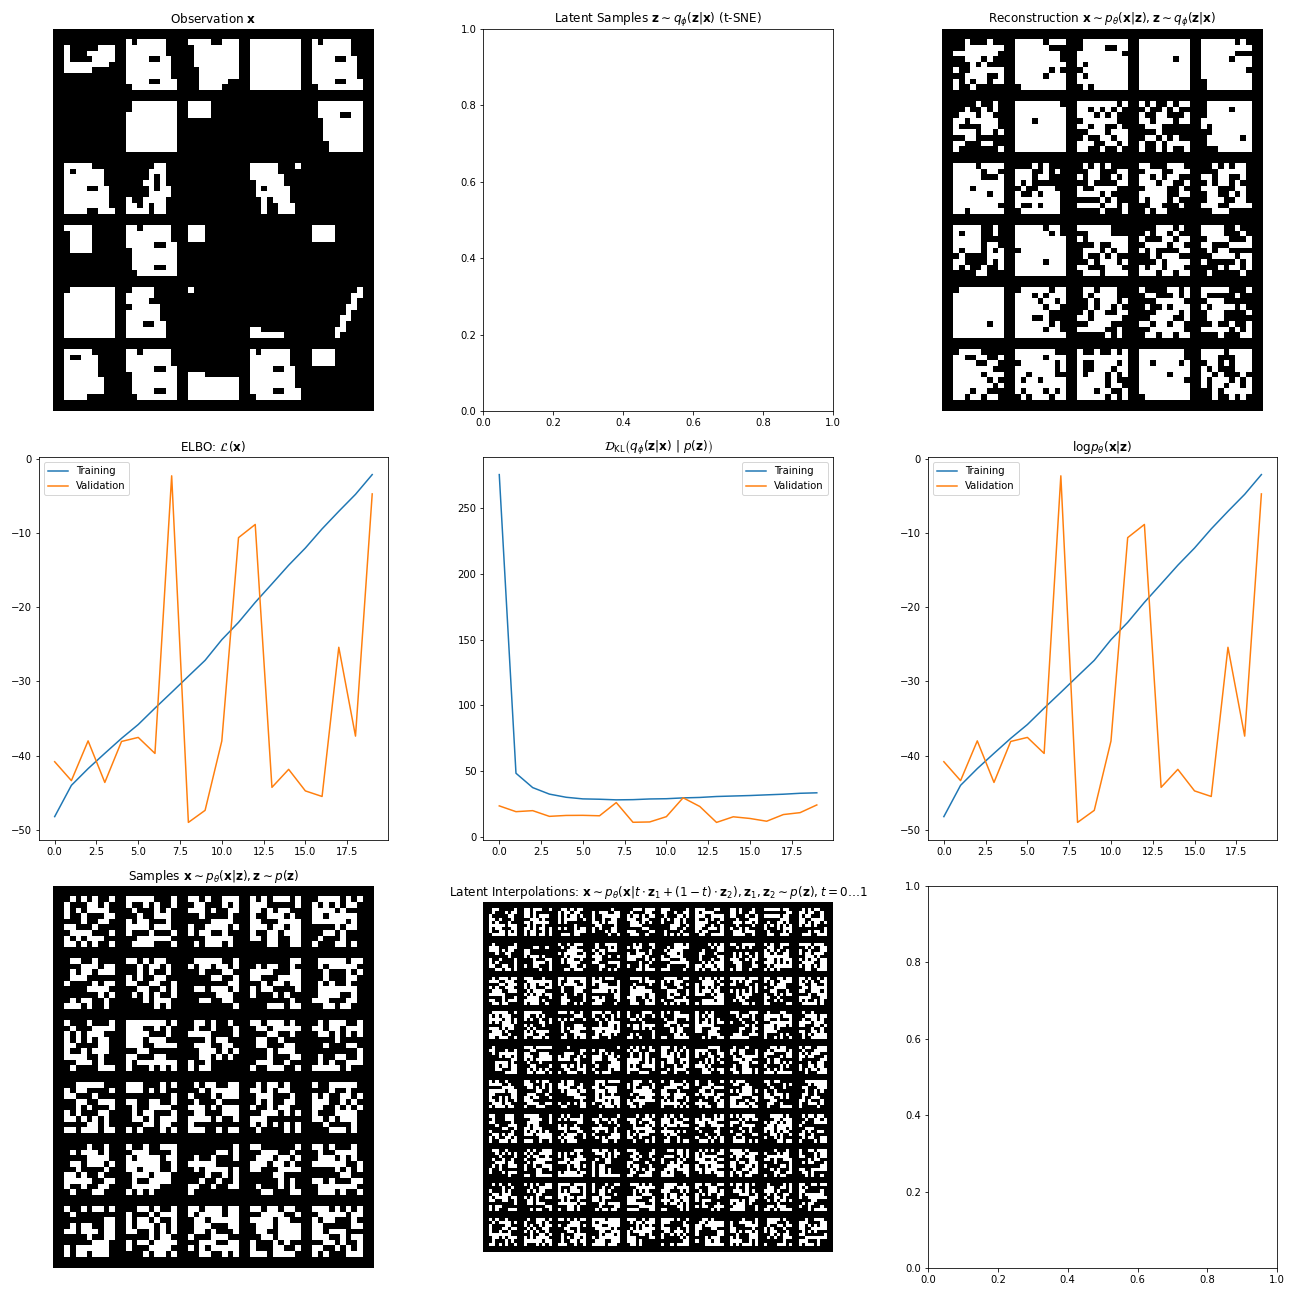

In [ ]:
num_epochs = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for i, batch in enumerate(train_dataloader, 1):
        X_img, _, _, y = batch
        #images1 = X_img[:,:,:,1]
        x = (X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(X_img.size()[0],9,9,1)
        #print(images1.shape)
        
        #x = torch.empty([images1.shape[0],81])
        #x = torch.empty([images1.shape[0],9,9,1])
        #print(images.shape)
        #for j, x1 in enumerate(images1):
          #print(x.shape)
          #x[j] = x1.view(9**2)
          #x[j] = x1
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        X_img,_,_, y = next(iter(val_dataloader))
        images1 = (X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(X_img.size()[0],9,9,1)
        #images1 = X_img[:,:,:,1]
        #print(images1.shape)
        
        #x = torch.empty([images1.shape[0],81])
        #print(images.shape)
        #for j, x1 in enumerate(images1):
          #print(x.shape)
        #  x[j] = x1.view(9**2)
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

In [ ]:
torch.save(vae.state_dict(), os.getcwd()+"/trained_vae_label2_ch1_vol3")

In [ ]:
#vae.state_dict()

### Validation/Test prediction loop

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

NameError: ignored

### Final results

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['0','1','2','3','4','5','6','7','8']))

validation
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.77      0.29      0.42     11543
           2       0.02      0.09      0.03       283
           3       0.07      0.94      0.13       543
           4       0.07      0.09      0.08       375
           5       0.41      0.33      0.36       367
           6       0.00      0.00      0.00       102
           7       1.00      0.01      0.01       185
           8       0.88      0.01      0.02       849

    accuracy                           0.28     14247
   macro avg       0.36      0.19      0.12     14247
weighted avg       0.71      0.28      0.36     14247



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.sort(data_train.labelC.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object)

In [ ]:
class_weights

[0.23697180546495614,
 4.500344115622849,
 1.347691673536686,
 0.22195444825362343,
 0.4562835810480776,
 934.1428571428571,
 0.4635616049907841,
 1.9484505363528009,
 0.06535144264883719,
 1.0]